In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from IPython.display import clear_output

Round 1/100
Global Reward: -1.30
Agent Rewards: [-3.803590968539246, -4.874099999999999, -0.7965163698481017]
Confidence Factors: [0.7446937074825847, 0.2553062925174154]
Round 2/100
Global Reward: -2.50
Agent Rewards: [-4.130496367682906, -3.7777513098018694, -0.7174035532728182]
Confidence Factors: [0.41271691035390085, 0.5872830896460992]
Round 3/100
Global Reward: -0.76
Agent Rewards: [-3.0036210202617415, -3.709896643745866, -0.6467973792252842]
Confidence Factors: [0.669577687089148, 0.3304223129108521]
Round 4/100
Global Reward: -0.65
Agent Rewards: [-2.8266216706354172, -3.6491848588889604, -0.5477037927333736]
Confidence Factors: [0.6947801627832313, 0.3052198372167687]
Round 5/100
Global Reward: 0.15
Agent Rewards: [-3.283803215593552, -3.259555219135496, -0.5004135159117161]
Confidence Factors: [0.4939382978884669, 0.5060617021115331]
Round 6/100
Global Reward: -0.50
Agent Rewards: [-2.8838911390896684, -3.2185474330368935, -0.43905822038760295]
Confidence Factors: [0.582891

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


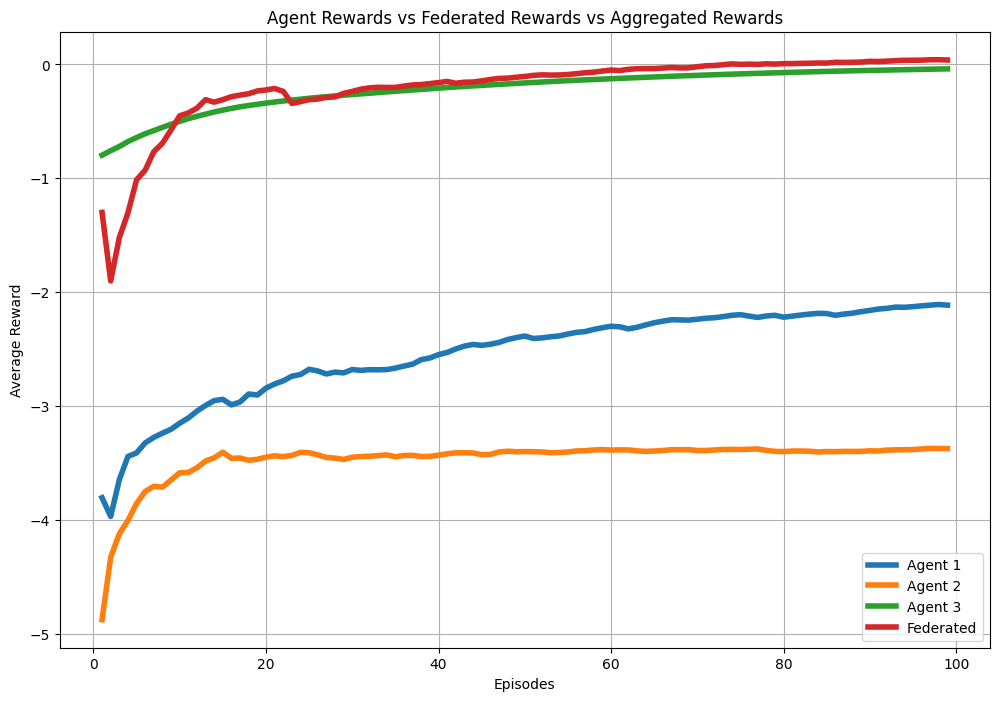

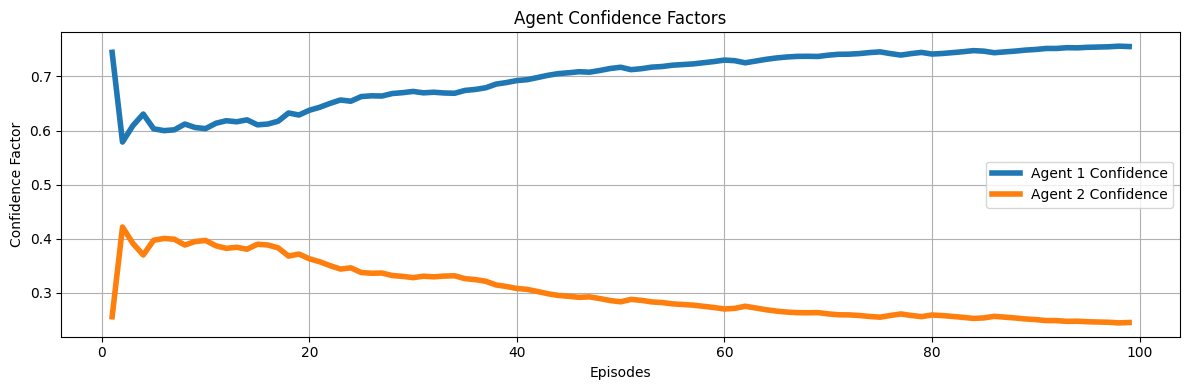

In [ ]:

class GridWorldEnv(gym.Env):
    def __init__(self,grid, size=5):
        super(GridWorldEnv, self).__init__()
        self.size = size
        self.action_space = gym.spaces.Discrete(4)  # Up, Down, Left, Right
        self.observation_space = gym.spaces.Box(low=0, high=size-1, shape=(2,), dtype=np.int32)
        self.max_steps = 200
        self.grid = grid

        self.reset()

        # Define colors for different states
        self.colors = ['white', 'lightgreen', 'lightblue']  # normal, grass, snowy
        self.cmap = ListedColormap(self.colors)

        # Create a figure and axis for rendering
        # self.fig, self.ax = plt.subplots()

    def reset(self):
        self.agent_pos = np.random.randint(0, self.size, size=2)
        self.goal_pos = [self.size-1, self.size-1]
        self.current_step = 0
        return self._get_observation()
    def step(self, action):
        agent_id=self.agent_id
        self.current_step += 1

        # Move agent
        if action == 0:  # Up
            self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1:  # Down
            self.agent_pos[0] = min(self.size - 1, self.agent_pos[0] + 1)
        elif action == 2:  # Left
            self.agent_pos[1] = max(0, self.agent_pos[1] - 1)
        elif action == 3:  # Right
            self.agent_pos[1] = min(self.size - 1, self.agent_pos[1] + 1)

        # Check if goal is reached
        done = np.array_equal(self.agent_pos, self.goal_pos)

        # Calculate reward
        x, y = self.agent_pos
        if done:
            reward = 10

        else:
          if self.grid[x, y] == 0:
            reward = -1
          elif self.grid[x, y] == 1:
            reward = -2
          elif self.grid[x, y] == 2:
            reward = -3





        return self._get_observation(), reward, done or self.current_step >= self.max_steps, {}
    def _get_observation(self):
        return self.agent_pos.copy()

    def render(self, mode='human'):
        if mode == 'human':
            self.ax.clear()  # Clear the previous plot
            self.ax.imshow(self.grid, cmap=self.cmap, vmin=0, vmax=2)
            self.ax.plot(self.agent_pos[1], self.agent_pos[0], 'ro', markersize=10)
            self.ax.plot(self.goal_pos[1], self.goal_pos[0], 'go', markersize=10)
            self.ax.set_title(f'Step: {self.current_step}')
            self.ax.axis('off')
            plt.draw()
            plt.pause(0.1)

    def close(self):
        plt.close(self.fig)


class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        return F.softmax(self.fc(x), dim=-1)

class Agent:
    def __init__(self, input_size, output_size, states_properties, render=False):
        self.policy = PolicyNetwork(input_size , output_size)  # Multiply by 2 to account for state mask
        self.optimizer = optim.Adam(self.policy.parameters(), lr=0.001)
        self.states_properties = states_properties
        self.recent_rewards = []
        self.render = render

    def select_action(self, state):
        state_tensor = torch.FloatTensor(state)  # Add this line

        probs = self.policy(state_tensor)

        m = Categorical(probs)
        action = m.sample()
        log_prob = m.log_prob(action)

        return action.item(), log_prob

    def train(self, env, num_episodes):
        for episode in range(num_episodes):
            state = env.reset()
            log_probs = []
            rewards = []
            done = False
            true_rew=[]

            while not done:
                action, log_prob = self.select_action(state)
                next_state, reward, done, _ = env.step(action)

                # Adjust reward based on agents knowledge
                x, y = state
                rew=reward
                if env.grid[x, y] not in self.states_properties:
                  rew = -10
                log_probs.append(log_prob)
                rewards.append(reward)
                true_rew.append(rew)
                state = next_state

            self.recent_rewards.append(np.mean(true_rew))

            # Update policy
            returns = self._compute_returns(rewards)
            policy_loss = 0
            for log_prob, R in zip(log_probs, returns):
                policy_loss += -log_prob * R
            self.optimizer.zero_grad()
            policy_loss.backward()
            self.optimizer.step()

    def _compute_returns(self, rewards, gamma=0.99):
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        returns = torch.tensor(returns)
        if len(returns) > 1:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns

    def get_policy_params(self):
        return {name: param.data.clone() for name, param in self.policy.named_parameters()}

    def get_recent_rewards(self):
        return self.recent_rewards

class AdaptiveConfidenceWeightedAggregator:
    def __init__(self, num_agents):
        self.num_agents = num_agents
        self.confidence_factors = [1.0] * num_agents

    def aggregate_policies(self, agent_policies, agent_rewards):
        # Update confidence factors based on agent performance
        total_reward = sum(np.exp(np.mean(rewards)) for rewards in agent_rewards)
        self.confidence_factors = [np.exp(np.mean(rewards))/ total_reward for rewards in agent_rewards]

        # Aggregate policies using confidence factors
        aggregated_policy = {}
        for param_name in agent_policies[0].keys():
            weighted_params = [cf * policy[param_name] for cf, policy in zip(self.confidence_factors, agent_policies)]
            aggregated_policy[param_name] = sum(weighted_params) / sum(self.confidence_factors)

        return aggregated_policy

    def get_confidence_factors(self):
        return self.confidence_factors


class CentralServer:
    def __init__(self, input_size, output_size, num_agents):
        self.global_policy = PolicyNetwork(input_size , output_size)
        self.aggregator = AdaptiveConfidenceWeightedAggregator(num_agents)
        self.confidence_factors_history = []

    def aggregate_policies(self, agents):
        agent_policies = [agent.get_policy_params() for agent in agents]
        agent_rewards = [agent.get_recent_rewards() for agent in agents]

        aggregated_policy = self.aggregator.aggregate_policies(agent_policies, agent_rewards)
        self.confidence_factors_history.append(self.aggregator.get_confidence_factors())

        self.global_policy.load_state_dict(aggregated_policy)

    def distribute_global_policy(self, agents):
        for agent in agents:
            agent.policy.load_state_dict(self.global_policy.state_dict())

    def get_confidence_factors(self):
        return self.aggregator.get_confidence_factors()
def create_agents(num_agents, input_size, output_size, states_properties):
    agents = []

    for i in range(num_agents):
      agent = Agent(input_size, output_size, states_properties[i])
      agents.append(agent)
    return agents
def run_federated_learning(env, num_rounds, num_episodes_per_round, num_agents, states_properties):

    input_size = 2  # [x, y]
    output_size = 4  # Up, Down, Left, Right
    agents = create_agents(num_agents, input_size, output_size, states_properties)
    fully_familiare_agent_with_rewards = agents[-1]  # The last agent knows all the rewards
    federated_agents = agents[:-1]  # Exclude the last agent from federated learning

    central_server = CentralServer(input_size, output_size, num_agents - 1)

    global_rewards = []
    agent_rewards = [[] for _ in agents]
    for round in range(num_rounds):
        print(f"Round {round + 1}/{num_rounds}")

        # Local training
        for i, agent in enumerate(federated_agents):
            env.agent_id=i
            agent.recent_rewards=[]
            agent.train(env, num_episodes_per_round)
            agent_rewards[i].append(np.mean(agent.recent_rewards))

        # Train excluding the agent with fully familiare with rewards  separately
        fully_familiare_agent_with_rewards.train(env, num_episodes_per_round)
        agent_rewards[-1].append(np.mean(fully_familiare_agent_with_rewards.recent_rewards))

        # Policy aggregation (excluding the agent with fully familiare with rewards )
        central_server.aggregate_policies(federated_agents)

        # Policy distribution (excluding the agent with fully familiare with rewards )
        central_server.distribute_global_policy(federated_agents)

        # Evaluate global policy
        env.agent_id=2
        global_reward = evaluate_global_policy(central_server.global_policy, env, num_episodes_per_round, input_size)
        global_rewards.append(global_reward)

        print(f"Global Reward: {global_reward:.2f}")
        print(f"Agent Rewards: {[reward[-1] for reward in agent_rewards]}")
        print(f"Confidence Factors: {central_server.get_confidence_factors()}")

    # Plot results
    plot_results(global_rewards, agent_rewards, central_server.confidence_factors_history)

def evaluate_global_policy(policy, env, num_episodes, input_size=2):
    total_reward = 0
    total_reward1=0
    total_reward2=0
    for _ in range(num_episodes):
        state = env.reset()
        done = False

        episode_reward = []
        step = 0

        while not done:

            state_tensor = torch.FloatTensor(state)
            action = torch.argmax(policy(state_tensor)).item()
            next_state, reward, done, _ = env.step(action)

            episode_reward.append(reward)
            state = next_state
            step += 1

        total_reward += np.mean(episode_reward)
    return total_reward / num_episodes


import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def plot_results(global_rewards, agent_rewards, confidence_factors_history, window_size=100):
    episodes = len(global_rewards)
    agent1_rewards=agent_rewards[0]
    agent2_rewards=agent_rewards[1]
    fully_familiare_agent_with_rewards = agent_rewards[2]
    federated_rewards = global_rewards
    # Calculate aggregated reward (sum of agent rewards)
    aggregated_rewards = [a1 + a2 for a1, a2 in zip(agent1_rewards, agent2_rewards)]

    plt.figure(figsize=(12, 8))

    data1=agent1_rewards
    data2=agent2_rewards
    data3=fully_familiare_agent_with_rewards
    data4=federated_rewards
    mean_data1=[]
    mean_data2=[]
    mean_data3=[]
    mean_data4=[]
    for i in range(0, len(data1)):
      mean_data1.append(np.mean(data1[0:i]))
      mean_data2.append(np.mean(data2[0:i]))
      mean_data3.append(np.mean(data3[0:i]))
      mean_data4.append(np.mean(data4[0:i]))
    plt.plot(mean_data1, label='Agent 1',linewidth=4)
    plt.plot(mean_data2, label='Agent 2',linewidth=4)
    plt.plot(mean_data3, label='Agent 3',linewidth=4)

    plt.plot(mean_data4, label='Federated',linewidth=4)

    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.title('Agent Rewards vs Federated Rewards vs Aggregated Rewards')
    plt.legend()
    plt.grid(True)

    # Plot confidence factors
    plt.figure(figsize=(12, 4))
    cf1, cf2 = zip(*confidence_factors_history)
    data5=cf1
    data6=cf2
    mean_data5=[]
    mean_data6=[]
    for i in range(0, len(data5)):
      mean_data5.append(np.mean(data5[0:i]))
      mean_data6.append(np.mean(data6[0:i]))
    plt.plot(range(len(cf1)), mean_data5, label='Agent 1 Confidence',linewidth=4)
    plt.plot(range(len(cf2)), mean_data6, label='Agent 2 Confidence',linewidth=4)
    plt.xlabel('Episodes')
    plt.ylabel('Confidence Factor')
    plt.title('Agent Confidence Factors')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Run the federated learning process
num_agents = 3
num_rounds = 100
num_episodes_per_round = 100
size = 10

grid = np.random.choice([0, 1, 2], size=(size, size))  # 0: normal, 1: grass, 2: snowy

env = GridWorldEnv(grid, size)


num_episodes = 100
states_properties=[[0,1],[0,2],[0,1,2]]
run_federated_learning(env, num_rounds, num_episodes_per_round, num_agents, states_properties)